In [56]:
import numpy as np 
import gym
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
import pandas as pd
import GPUtil

from gym import Env, spaces

pd.options.display.max_rows = 12

#get a matrix of distances between locations
df = pd.read_csv('dist_vologda_matrix.csv', sep=',')
df = df.iloc[:, 1:]

#some parameters
working_hours = 12
truck_speed = 60

df = df / 1000
df

,АЗС №35400 Кичменгский Городок,АЗС №35401 Великий Устюг-1,АЗС №35402 Великий Устюг-2,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35406 Журавлево,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,99.2272,101.8513,139.2135,154.2522,777.2635,102.4328,520.5020,517.8863,266.7014,...,610.3886,610.3028,607.3283,609.0579,611.0852,611.0605,604.2684,605.7555,502.9826,477.9325
1,99.0684,0.0000,4.9465,134.5201,149.5589,748.0318,5.5280,491.2703,488.6546,241.7276,...,581.1570,581.0711,578.0967,579.8263,581.8535,581.8288,575.0368,576.5238,473.7510,448.7008
2,101.8148,5.0688,0.0000,137.2665,152.3053,750.7781,3.0302,494.0166,491.4010,244.4739,...,583.9033,583.8174,580.8430,582.5726,584.5999,584.5752,577.7831,579.2702,476.4973,451.4472
3,139.2135,134.6791,137.3031,0.0000,15.0961,613.5690,137.8846,356.8075,354.1918,107.2648,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
4,154.2522,149.7178,152.3419,15.0961,0.0000,613.8947,152.9234,357.1332,354.5176,107.5905,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,611.7861,582.6174,585.2414,447.9957,448.3214,191.2351,585.8229,181.8523,179.2367,345.2112,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
60,605.7962,576.6275,579.2515,442.0057,442.3315,185.0682,579.8330,175.8624,173.2467,339.2213,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
61,607.1467,577.9779,580.6020,443.3562,443.6820,186.4186,581.1835,177.2129,174.5972,340.5717,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
62,504.6641,475.4954,478.1194,340.8736,341.1994,274.3706,478.7009,74.7303,72.1146,238.0892,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [57]:
#remove locations, which cannot be served in 12 hours (driver can't get there and come back in 12 hours)
to_remove = ((2 * (df.values[-1,:] / truck_speed) < working_hours) == False).nonzero()[0]
df = df.drop(df.index[to_remove])
df = df.drop(df.columns[to_remove], axis=1)
df = df.reset_index(drop=True)
df

,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,АЗС №35410 Сазоново-1,АЗС №35411 Сазоново-2,АЗС №35412 Вытегра,АЗС №35413 Липник,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,15.0961,613.5690,356.8075,354.1918,107.2648,619.0077,618.5201,629.3182,472.6696,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
1,15.0961,0.0000,613.8947,357.1332,354.5176,107.5905,619.3335,618.8458,629.6440,472.9954,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
2,615.1980,615.5238,0.0000,349.0547,346.4390,512.4135,142.9597,142.4720,165.8965,193.2966,...,187.4480,187.3622,184.7850,188.3816,183.6881,191.1772,185.1426,186.6296,274.4141,309.3918
3,356.1259,356.4516,349.7479,0.0000,3.7018,253.3414,355.1867,354.6990,373.5276,216.8790,...,182.8731,182.7873,179.8128,181.5424,183.5697,183.5450,176.7529,178.2400,75.4671,45.6714
4,353.5507,353.8764,347.1727,3.7422,0.0000,250.7662,352.6115,352.1238,370.9524,214.3038,...,180.2979,180.2120,177.2376,178.9672,180.9945,180.9698,174.1777,175.6648,72.8919,43.0962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,447.9957,448.3214,191.2351,181.8523,179.2367,345.2112,196.6738,196.1861,332.9386,176.2900,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
52,442.0057,442.3315,185.0682,175.8624,173.2467,339.2213,190.5069,190.0192,326.9487,170.3001,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
53,443.3562,443.6820,186.4186,177.2129,174.5972,340.5717,191.8574,191.3697,328.2991,171.6506,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
54,340.8736,341.1994,274.3706,74.7303,72.1146,238.0892,279.8093,279.3216,346.5072,189.8586,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [58]:
from numpy.random import default_rng

#shrink array
#df = df.iloc[40:56,40:56]
rng = default_rng()
idx = rng.choice(len(df.values[0])-1, size=len(df.values[0]) - 1 - 15, replace=False)
print(idx)
df = df.drop(df.index[idx])
df = df.drop(df.columns[idx], axis=1)
df = df.reset_index(drop=True)
N = len(df.values[0])
print(N)
df

[32 14 23 31 21 43  8 25 47  0 50 42 49 33 11 48 15 34 51 36  4 54  2 46
 26 22 30 16 27 45 13 10 20 17 28 53  9 52 37 35]
16


,АЗС №35404 Нюксеница,АЗС №35407 Грязовец-1,АЗС №35409 Савино,АЗС №35410 Сазоново-1,АЗС №35411 Сазоново-2,АЗС №35416 Тарногский Городок,АЗС №35422 с. Бабушкина,АЗС №35426 Сямжа,АЗС №35432 Ботово,АЗС №35437 Харовск,АЗС №35446 Чернышевского-2,АЗС №35447 Ленинградская,АЗС №35448 Водников,АЗС №35449 Нелазское,АЗС №35452 Металлургов,Нефтебаза
0,0.0000,357.1332,107.5905,619.3335,618.8458,45.5576,137.9094,292.3817,424.3666,343.6038,307.0136,314.3989,311.9798,448.4384,445.7062,314.5638
1,356.4516,0.0000,253.3414,355.1867,354.6990,373.4785,283.5434,160.0557,160.2198,157.6186,49.7193,46.2594,48.1030,184.2916,181.5594,45.6714
2,110.5703,253.8591,0.0000,516.0593,515.5716,127.5972,30.4562,189.1075,321.0925,240.3297,203.7395,211.1247,208.7056,345.1642,342.4321,211.2896
3,620.9251,354.4560,517.8149,0.0000,0.4877,637.9520,548.0168,424.5292,195.6790,422.0921,313.9691,307.9653,313.9466,171.1698,189.4785,314.7931
4,620.4374,353.9683,517.3272,0.4877,0.0000,637.4643,547.5292,424.0415,195.1913,421.6044,313.4814,307.4776,313.4589,170.6821,188.9909,314.3054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,314.9659,46.5661,211.8557,307.8248,307.3371,331.9928,242.0576,118.5699,112.8580,116.1328,8.2335,0.0000,8.2110,136.9298,134.1976,9.0576
12,311.7647,48.5429,208.6545,314.1274,313.6397,328.7916,238.8565,115.3688,119.1606,112.9317,5.0324,7.4531,0.0000,143.2323,140.5002,5.5894
13,449.9896,183.5206,346.8794,171.3325,170.8449,467.0165,377.0814,253.5937,24.7435,251.1566,143.0336,137.0298,143.0111,0.0000,18.2921,143.8577
14,447.0774,180.6083,343.9672,189.0456,188.5580,464.1043,374.1691,250.6815,21.8313,248.2443,140.1213,134.1176,140.0989,18.1506,0.0000,140.9454


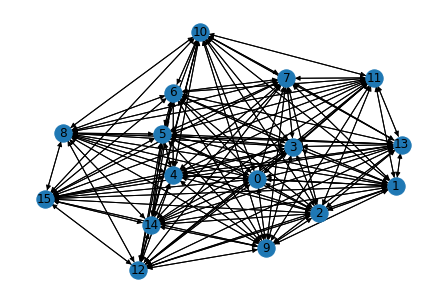

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(df.values, create_using=nx.DiGraph)
nx.draw(G, with_labels = True)
plt.show()

In [60]:
#custom gym environment for our problem
m = 5
N = len(df.values[0])
working_hours = 12
truck_speed = 60

class TransportScape(Env):
    def __init__(self, env_config):
        self.num_of_trucks = m
        self.num_of_locations = N
        self.h = working_hours #working hours of each truck driver
        self.speed = truck_speed
        self.distances = df.values #an array, containing distances between locations
    
        self.action_space = spaces.MultiDiscrete([self.num_of_trucks, self.num_of_locations - 1])
    
        self.observation_space = spaces.Dict(
        {
            #x_i - shows each truck's location
            'truck location': spaces.MultiDiscrete(np.full(self.num_of_trucks, self.num_of_locations)),
            #p_j - shows whether a truck is assigned to this particular location or not
            'assignment': spaces.MultiBinary(self.num_of_locations - 1), 
            #u_i - shows whether a particular truck was used before
            'truck usage': spaces.MultiBinary(self.num_of_trucks),
            #delta_i - shows how much time each truck has left until the end of the work day
            'time left': spaces.Box(low=np.zeros(self.num_of_trucks), high=np.full(self.num_of_trucks, self.h), dtype=np.float64)
        })
        self.reset()
        
    def nice_print(self):
        print("Truck Location")
        print(self.state['truck location'])
        print("Assignment")
        print(self.state['assignment'])
        print("Truck Usage")
        print(self.state['truck usage'])
        print("Time Left")
        print(self.state['time left'])
        
    def reset(self):
        self.state = {'truck location': np.full(self.num_of_trucks, self.num_of_locations - 1),
                      'assignment': np.zeros(self.num_of_locations - 1),
                      'truck usage': np.zeros(self.num_of_trucks),
                      'time left': np.full(self.num_of_trucks, self.h)}
        self.done = False
        return self.state 
    
    def step(self, action):
        i, j = action[0], action[1]
        truck_loc = self.state['truck location']
        assignment = self.state['assignment']
        truck_use = self.state['truck usage']
        time_left = self.state['time left']
        
        #if a truck is already assigned to this location - penalty
        if assignment[j] == 1:
            self.reward = -6000
        #if no time left - penalty
        elif (time_left[i] - self.distances[truck_loc[i], j] / self.speed - self.distances[j, -1] / self.speed) < 0:
            self.reward = -6000
        #else - assign truck to a new location
        else:
            self.reward = 0
            #print("else")
            #if needs to use an unused before truck - penalty
            if truck_use[i] == 0:
                self.reward = -2000
                truck_use[i] = 1
            assignment[j] = 1
            self.reward -= self.distances[truck_loc[i], j]
            time_left[i] -= self.distances[truck_loc[i], j] / self.speed - 0.5
            truck_loc[i] = j
        #if all locations have trucks assigned to them - end episode
        if np.all(assignment == 1):
            self.done = True
        else:
            self.done = False
        
        self.state['truck location'] = truck_loc
        self.state['assignment'] = assignment
        self.state['truck usage'] = truck_use
        self.state['time left'] = time_left
        
        return self.state, self.reward, self.done, {}

In [61]:
config = ppo.DEFAULT_CONFIG.copy()
config["num_workers"] = 8
config["framework"] = "torch"
#config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['kl_coeff'] = 0.0 #можно поменять
config["log_level"] = "ERROR"
config["env_config"] = {}
config["clip_param"] = 0.3
config["entropy_coeff"] = 0.01
config['lr'] = 0.0001
config["horizon"] = N #numbers of t_steps after which termiate
config["train_batch_size"] = 4000 
config["rollout_fragment_length"] = 500 # batch_size per worker

In [62]:
ray.shutdown()
ray.init()

2022-06-06 10:43:58,813	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8266


RayContext(dashboard_url='127.0.0.1:8266', python_version='3.8.13', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.76', 'raylet_ip_address': '192.168.1.76', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-06_10-43-56_190320_116359/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-06_10-43-56_190320_116359/sockets/raylet', 'webui_url': '127.0.0.1:8266', 'session_dir': '/tmp/ray/session_2022-06-06_10-43-56_190320_116359', 'metrics_export_port': 65495, 'gcs_address': '192.168.1.76:39252', 'address': '192.168.1.76:39252', 'node_id': '25864e417ef16b7f436b9e7384e59e012eda2983ad81f2f04ada3cd8'})

In [63]:
agent = ppo.PPOTrainer(config=config, env=TransportScape)

In [64]:
import datetime
start = datetime.datetime.now()
print(start)

for i in range(1001):
    result = agent.train()
    if i % 10 == 0:
        print('i: ', i)
        print('mean episode length:', result['episode_len_mean'])
        print('max episode reward:', result['episode_reward_max'])
        print('mean episode reward:', result['episode_reward_mean'])
        print('min episode reward:', result['episode_reward_min'])
        print('total episodes:', result['episodes_total'])
        checkpoint = agent.save()
finish = datetime.datetime.now()
print(finish)
duration = finish - start
print("Total Hours: ", duration.total_seconds() / 3600)

2022-06-06 10:44:09.980370
i:  0
mean episode length: 16.0
max episode reward: -35848.8886
mean episode reward: -56398.73328750001
min episode reward: -71458.5543
total episodes: 248
i:  10
mean episode length: 16.0
max episode reward: -36030.150299999994
mean episode reward: -53437.021473387096
min episode reward: -72683.26539999999
total episodes: 2744
i:  20
mean episode length: 16.0
max episode reward: -33504.1898
mean episode reward: -49829.15731451613
min episode reward: -68904.7242
total episodes: 5248
i:  30
mean episode length: 16.0
max episode reward: -30133.9938
mean episode reward: -45893.40542258064
min episode reward: -65323.8072
total episodes: 7744
i:  40
mean episode length: 16.0
max episode reward: -29544.385000000002
mean episode reward: -45750.56427217741
min episode reward: -65424.9475
total episodes: 10248
i:  50
mean episode length: 16.0
max episode reward: -29880.2761
mean episode reward: -45658.96039596774
min episode reward: -67164.5598
total episodes: 12744
i

i:  490
mean episode length: 15.220532319391635
max episode reward: -11717.3579
mean episode reward: -20742.753671863116
min episode reward: -74859.7579
total episodes: 123642
i:  500
mean episode length: 15.181818181818182
max episode reward: -11710.032099999999
mean episode reward: -17827.095036363637
min episode reward: -63293.092899999996
total episodes: 126232
i:  510
mean episode length: 15.113636363636363
max episode reward: -11710.032099999999
mean episode reward: -16111.82302992424
min episode reward: -69023.16619999998
total episodes: 128844
i:  520
mean episode length: 15.459143968871595
max episode reward: -11717.4508
mean episode reward: -32053.337597665373
min episode reward: -82863.1676
total episodes: 131439
i:  530
mean episode length: 15.132575757575758
max episode reward: -11717.4508
mean episode reward: -16690.69903371212
min episode reward: -66926.1688
total episodes: 134046
i:  540
mean episode length: 15.212927756653992
max episode reward: -11717.4508
mean episod

i:  940
mean episode length: 15.335877862595419
max episode reward: -11709.8051
mean episode reward: -24762.57548015267
min episode reward: -75403.3627
total episodes: 241016
i:  950
mean episode length: 15.166666666666666
max episode reward: -11709.061700000002
mean episode reward: -18000.71378409091
min episode reward: -72971.962
total episodes: 243631
i:  960
mean episode length: 15.413127413127413
max episode reward: -11707.350900000001
mean episode reward: -27506.60488841699
min episode reward: -69555.6028
total episodes: 246243
i:  970
mean episode length: 15.836653386454183
max episode reward: -11707.350900000001
mean episode reward: -45711.531194820716
min episode reward: -80376.0041
total episodes: 248855
i:  980
mean episode length: 15.367816091954023
max episode reward: -11707.350900000001
mean episode reward: -25633.614596551724
min episode reward: -74438.2387
total episodes: 251466
i:  990
mean episode length: 15.94820717131474
max episode reward: -11710.032099999999
mean 

In [65]:
env = TransportScape(config)
state = env.reset()
g = 0
done = False
reward = 0
actions = []
i = 0
while not done:
    action = agent.compute_action(state, explore = False)
    actions.append(action)
    print("action: {:}; reward: {:}".format(action, reward))
    state, reward, done, info = env.step(action)
    g += reward
    i += 1
    if i == 1000:
        break
print("Final state:")
print("Assignment:", state['assignment'])
print("Trucks used:", state['truck usage'])
print("Time left", state['time left'])
print(g) 

action: [0 0]; reward: 0
action: [ 1 12]; reward: -2314.5311
action: [ 2 10]; reward: -2006.1825
action: [2 6]; reward: -2007.7988
action: [1 4]; reward: -233.7929
action: [4 8]; reward: -313.6397
action: [ 4 14]; reward: -2120.2162
action: [ 4 13]; reward: -21.339599999999997
action: [4 3]; reward: -18.150599999999997
action: [3 7]; reward: -171.3325
action: [2 2]; reward: -2118.1352
action: [ 2 11]; reward: -30.424400000000002
action: [2 1]; reward: -211.12470000000002
action: [3 9]; reward: -46.5661
action: [0 5]; reward: -52.951
Final state:
Assignment: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Trucks used: [1. 1. 1. 1. 1.]
Time left [6 7 2 9 7]
-11711.7429


In [66]:
truck_paths = {}
for k, v in actions:
    truck_paths.setdefault(k,[]).append(v)
for k in truck_paths:
    print("Truck #{:}: {:}".format(k,truck_paths[k]))

Truck #0: [0, 5]
Truck #1: [12, 4]
Truck #2: [10, 6, 2, 11, 1]
Truck #4: [8, 14, 13, 3]
Truck #3: [7, 9]


In [67]:
def GetLength(route):
    length = df.values[-1, route[0]]
    for i in range(1, len(route)):
        length += df.values[route[i-1], route[i]]
    length += df.values[route[-1], -1]
    
    return length

In [68]:
dist = 0
for k in truck_paths:
    dist += GetLength(truck_paths[k])
dist

2833.8459

In [69]:
for k in truck_paths:
    print(GetLength(truck_paths[k]) / truck_speed)

11.527989999999999
10.568793333333334
9.589638333333333
10.763866666666667
4.780476666666667
